## 1. Perkenalan

```
=================================================================================================

Nama : Abyan Naufal

The main objective of this project is to: Create a model to automate and speed up loan approvals, making them more accurate and less risky for fintech banks.
=================================================================================================
```

Problem Background
loan approval decisions are critical for financial institutions to balance profitability and risk. Incorrectly approving high-risk applicants can lead to financial losses due to defaults, while rejecting eligible applicants results in missed business opportunities. In Indonesia, where access to credit is vital for small businesses and individuals, manual loan evaluations are time-consuming and prone to errors. This project addresses the need for an automated, data-driven system to predict whether a loan applicant is likely to be approved or rejected based on their financial and personal attributes, improving efficiency and accuracy for banks like "GrowEasy."

Project Output
project delivers a machine learning model (XGBoost) that predicts loan approval status Approved or Rejected for new applicants. The model is saved as xgb_pipeline_model.pkl and can be used via a Jupyter notebook (`P1M2_ABYAN_inf.ipynb`) for inference. A web app deployment is planned to allow real-time predictions, enabling banks to input applicant data and receive instant approval decisions(deploy using hugging face).

Data
dataset used is the "Loan Approval Dataset" (sourced from [Kaggle](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset/data). It contains 4,269 rows and 12 columns (11 features + 1 target after dropping loan_id):
 Features:
  - Numerical (9): no_of_dependents, income_annum, loan_amount, loan_term, cibil_score, residential_assets_value, commercial_assets_value, luxury_assets_value, bank_asset_value.
  - Categorical (2): education (Graduate, Not Graduate), self_employed (Yes, No).
 Target: loan_status (Approved, Rejected).
 Characteristics: No missing values or duplicates. The dataset is slightly imbalanced (2,656 Approved vs. 1,613 Rejected), addressed using SMOTENC during modeling.
 Additional Features: Created loan_income_ratio and total_assets during EDA for deeper analysis.

Method

The project employs supervised learning for binary classification. The methodology includes:
Data Preprocessing: outlier capping, standard scaling for numerical features, one-hot encoding for categorical features, and SMOTENC for handling class imbalance.
Modeling: five algorithms were tested (KNN, SVM, Decision Tree, Random Forest, XGBoost). XGBoost was selected as the best model due to its high F1-score (0.9841) and recall (0.9813) on the test set.
Evaluation: models were evaluated using F1-score, recall, precision, accuracy, and ROC AUC, with cross-validation to ensure robustness. Hyperparameter tuning was performed using RandomizedSearchCV to optimize XGBoost. but focusing on looking on F1-score
Inference: the trained model is tested on new, raw data to predict loan approval status.
Deployment: using huggingface

## 2. Import Libraries

In [ ]:
# Import necessary libraries for data processing, visualization, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

## 3.Data Loading

In [ ]:
# Load the loan approval dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('loan_approval_dataset.csv')

In [ ]:
# Check for duplicated rows in the dataset and return the count
df.duplicated().sum()

0

no duplicated found on this data set

next, drop loan_id because it no need 

In [ ]:
# Drop the 'loan_id' column as it is not needed for modeling
df.drop(columns=['loan_id'], inplace=True)

In [ ]:
# Set pandas option to display all columns and show DataFrame information
pd.set_option('display.max_columns', None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0    no_of_dependents          4269 non-null   int64 
 1    education                 4269 non-null   object
 2    self_employed             4269 non-null   object
 3    income_annum              4269 non-null   int64 
 4    loan_amount               4269 non-null   int64 
 5    loan_term                 4269 non-null   int64 
 6    cibil_score               4269 non-null   int64 
 7    residential_assets_value  4269 non-null   int64 
 8    commercial_assets_value   4269 non-null   int64 
 9    luxury_assets_value       4269 non-null   int64 
 10   bank_asset_value          4269 non-null   int64 
 11   loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [ ]:
# Check for missing values in each column and return the count
df.isnull().sum()

 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

```
dataset has 12 columns with 4269 total data and has no missing value
```

next check summary of statisitc numerical columns and numerical columns

Summary Statistic Numerical Columns

In [ ]:
# Generate summary statistics for numerical columns in the DataFrame
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


Summary Statistic Categorical Columns

In [ ]:
# Select categorical columns and create a summary of their value counts
cat_cols=df.select_dtypes(include=object).columns.tolist()
cat_df=pd.DataFrame(df[cat_cols].melt(var_name='column', value_name='value')
                    .value_counts()).rename(columns={0: 'count'}).sort_values(by=['column', 'count'])
# Display summary statistics for categorical columns
display(df.select_dtypes(include=object).describe())
# Display the value counts for each categorical column
display(cat_df)

,education,self_employed,loan_status
count,4269,4269,4269
unique,2,2,2
top,Graduate,Yes,Approved
freq,2144,2150,2656


count
column         value               
 education      Not Graduate   2125
                Graduate       2144
 loan_status    Rejected       1613
                Approved       2656
 self_employed  No             2119
                Yes            2150

## 4. Exploratory Data Analysis (EDA)

on this EDA i'll do like 11 EDA which are : 
1. loan_status data distribution
2. income distribution
3. Education vs status loan
4. no of dependents vs loan_status
5. self employed vs loan_status
6. correlation heatmap
7. cibil score vs loan_status
8. distribution of loan to income ratio ( on this eda i will create new feature that is loan_income_ratio = loan_amount/income_annum)
9. loan term vs loan status
10. cibil score distribution by loan status
11. total asset vs loan status ( will create new feature total_asset = ressidential_assets_vallue + commercial asset value + luxury assets value + bank asset value)

next ill prepare things that need for next step 

first, ensure that all columns name no spaces

In [115]:
# Remove leading spaces from column names
df.rename(columns=lambda x: x.strip(), inplace=True)

# Display the updated DataFrame
print(df.columns)

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')


then create loan income ratio for distribution of loan to income ratio

In [116]:
df['loan_income_ratio'] = df['loan_amount'] / df['income_annum']

next create total assets column for total asset vs loan status

In [117]:
# Calculating total assets
df['total_assets'] = (
    df['residential_assets_value'] + 
    df['commercial_assets_value'] + 
    df['luxury_assets_value'] + 
    df['bank_asset_value']
)

i think all ready to go. then start doing EDA

#### 1. loan status data distribution (loan_status)

objective: To check the proportion of approved vs. rejected loans.

Insights to uncover:
   - How balanced are the target classes (Approved vs. Rejected)?
   - Is there any imbalance that we need to watch out for in the model?

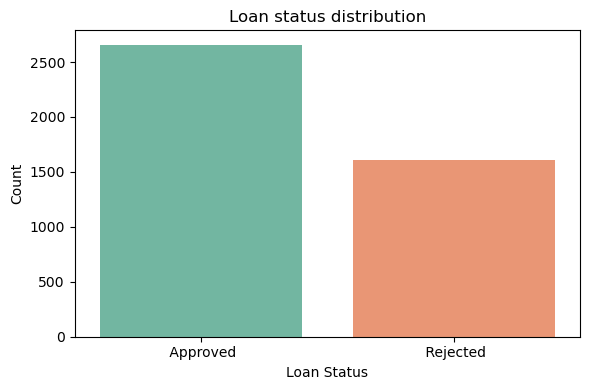

In [118]:
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df, palette='Set2')
plt.title('Loan status distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

```
The chart shows the distribution of loan statuses. how many got approved vs rejected. From the graph, it looks like around 2,600 loans were approved and about 1,600 were rejected. That means about 62% were approved and 38% were rejected.

So, the classes aren’t perfectly balanced. There's a bit of an imbalance, with more approvals than rejections. It's not extreme, but it's something to keep in mind when building a model, because models tend to favor the majority class.

To handle this, i might consider:
    Checking performance metrics like precision, recall, and F1-score for both classes.
    Using techniques like oversampling the minority class, undersampling the majority class, or adjusting class weights.
    Also, some models like XGBoost let us handle this imbalance more easily by tweaking certain parameters.
```

#### 2.Income Distribution (income_annum)

Objective:
To understand the range and distribution of applicant income.

Insights to uncover:
   - Is the distribution symmetric or skewed?
   - Are there any outliers or dominant income groups?

Text(0.5, 1.0, 'Income Distribution')

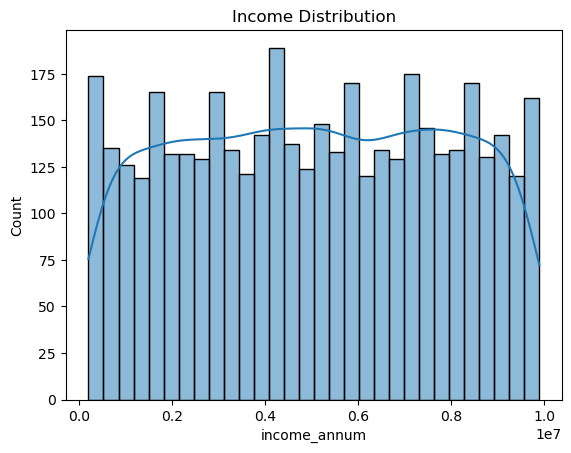

In [119]:
sns.histplot(df['income_annum'], bins=30, kde=True)
plt.title('Income Distribution')

```
chart shows how many applicants fall into each annual income range. The y-axis uses count, which just means it's telling us how many people are in each income group. That makes it easy to spot which income levels are the most common.

From the look of the chart, the distribution seems pretty balanced. there’s no big peak or steep drop, and the curve looks fairly even across the board. That means incomes are quite evenly spread out, with no strong skew to the left or right. Also, there aren’t any obvious outliers or super dominant income groups.

So overall, the income distribution looks uniform and stable, and using count here helps us quickly see how income is spread across all applicants.
```

#### 3. Education vs Status Loan

Objective:
To assess the impact of education level on the likelihood of loan approval.

Insights to uncover:
   - Are graduates more likely to be approved than non-graduates?
   - Is there a potential correlation useful for predictive modeling?

Text(0.5, 1.0, 'Education vs Status Loan')

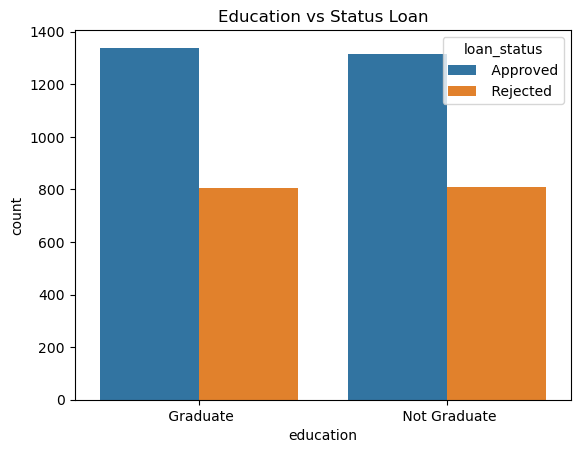

In [120]:
sns.countplot(x='education', hue='loan_status', data=df)
plt.title('Education vs Status Loan')

```
this chart shows how loan approval status compares between people who are graduates and those who aren’t. Interestingly, the number of approved loans is very similar in both groups around 1,350 approvals for both graduates and non graduates. The number of rejected loans is also nearly the same, about 800 in each group. This tells us that education level alone doesn’t seem to make a big difference in whether a loan gets approved or not.

If we expected graduates to have a clear advantage, the chart doesn’t show strong evidence of that. The approval rate is nearly equal between the two groups, so being a graduate doesn’t necessarily increase your chances of loan approval in this dataset.

This suggests that education may not be a strong standalone predictor for loan status. However, that doesn’t mean it’s not useful at all. it might still matter in combination with other features like income, employment type, or credit history. For example, maybe among high earners, education plays a different role.

Also, the fact that the approval rates are balanced across education levels might be a sign that the loan approval process is fair and not biased toward any specific education background, at least from what we can tell here.

For modeling, this means we probably shouldn’t rely too much on education as a key driver, but it’s still worth including and testing as part of the feature set. It may interact with other variables in ways that aren’t obvious from this single comparison.
```

#### 4.No of Dependents vs Status Loan

Objective:
To assess whether the number of dependents affects loan approval.

Insight to uncover:
Are applicants with more dependents more likely to be rejected?


Text(0.5, 1.0, 'No of Dependents vs Status Loan')

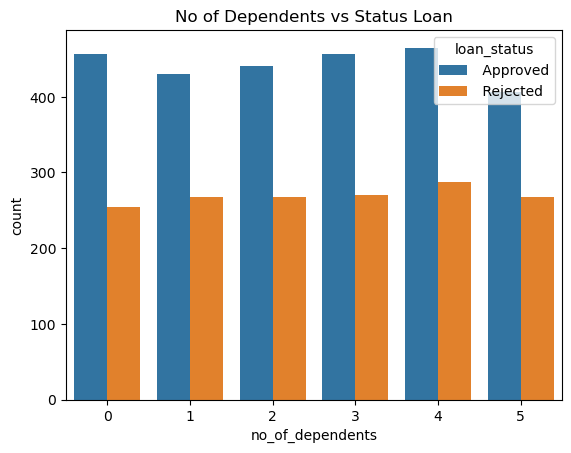

In [121]:
sns.countplot(x='no_of_dependents', hue='loan_status', data=df)
plt.title('No of Dependents vs Status Loan')


```
From chart that shows the number of dependents (tanggungan) a loan applicant has versus whether their loan got approved or rejected. The goal is to see if having more dependents makes it harder to get a loan approved.

So, the x-axis is the number of dependents, from 0 to 5, and the y-axis is the count of applicants. Blue bars are for rejected loans, and orange bars are for approved ones.

Here’s what I see:

    For 0 dependents, there are about 300 rejected and 450 approved. So, more people with no dependents got approved (nice!)
    For 1 dependent, it’s around 280 rejected and 400 approved. Still, more approvals, but the gap’s a bit smaller.
    For 2 dependents, it’s roughly 270 rejected and 410 approved. Same trend—more approvals.
    For 3 dependents, about 260 rejected and 420 approved. Approvals are still higher.
    For 4 dependents, it’s around 300 rejected and 430 approved. Approvals lead again.
    For 5 dependents, it’s about 270 rejected and 400 approved. Approvals still win.

Now, let’s think about the big question: Are applicants with more dependents more likely to get rejected? Honestly, it doesn’t seem like it. Across all numbers of dependents, the orange bars (approved) are consistently taller than the blue bars (rejected). The difference between approvals and rejections doesn’t seem to grow or shrink much as the number of dependents increases. Like, someone with 5 dependents isn’t getting rejected way more than someone with 0—it’s pretty steady.

If we dig a bit deeper, the rejection rate (blue bars) stays around 260–300 no matter how many dependents someone has, while approvals are always higher, around 400–450. So, having more dependents doesn’t seem to make the bank say “no” more often.

Based on this chart, having more dependents doesn’t really make it more likely for a loan to get rejected. The approval rate stays higher across the board, whether someone has 0 or 5 dependents. Maybe the bank/lender cares more about other stuff, like income or credit history, rather than how many people you’re supporting.
```

#### 5. Self Employed vs loan status

Objective: To see if self-employed individuals are harder to get approved for loans.
Insight:
   - Any potential bias related to employment status.

Text(0.5, 1.0, 'Self Employed vs loan status')

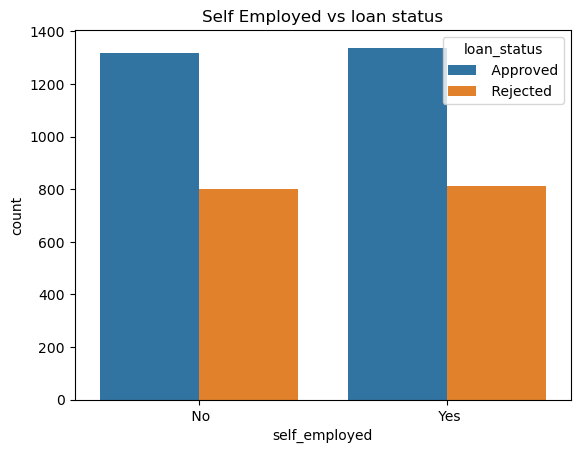

In [122]:
sns.countplot(x='self_employed', hue='loan_status', data=df)
plt.title('Self Employed vs loan status')

```
im checking if being self-employed makes it tougher to get a loan approved, and whether there might be some bias based on job status. The x-axis shows employment status (“No” for self-employed, “Yes” for not self-employed), and the y-axis is the count of loan applications. Blue bars are approved loans, and orange bars are rejected ones.

Here’s the rundown:

    For “No” (self-employed), we’ve got about 1300 approved and 800 rejected. So, more self-employed folks got their loans approved.
    For “Yes” (not self-employed), it’s around 1400 approved and 800 rejected. Again, more approvals than rejections.

Now, let’s think about the main question that **Is it harder for self-employed people to get approved?** then answer is Not really!. Both groups have way more approvals than rejections, and the difference between approved and rejected is pretty similar like about 500 more approvals for both. The self-employed group (1300 vs 800) isn’t lagging behind the non-self-employed (1400 vs 800) by much, if at all.

There doesn’t seem to be a big bias against self-employed folks here. Both groups get approved more often, and the rejection rates are about the same (around 800). The bank seems to treat self-employed and non-self-employed applicants fairly evenly. Maybe they’re looking at other factors like income or credit score instead of just job status.
```

#### 6. Numerical Correlation Heatmap

Objective:
To explore the correlation between numerical variables such as:
Income, loan amount, cibil score, and assets.

Insight to uncover:
Which features have the strongest correlation with loan_amount or loan_status (if encoded)?

In [123]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Apply label encoding to 'loan_status' column
df['loan_status'] = label_encoder.fit_transform(df['loan_status'])

# Display DataFrame that already erencoded
print(df[['education', 'self_employed','loan_status']])

df['loan_status'] = 1 - df['loan_status']

          education self_employed  loan_status
0          Graduate            No            0
1      Not Graduate           Yes            1
2          Graduate            No            1
3          Graduate            No            1
4      Not Graduate           Yes            1
...             ...           ...          ...
4264       Graduate           Yes            1
4265   Not Graduate           Yes            0
4266   Not Graduate            No            1
4267   Not Graduate            No            0
4268       Graduate            No            0

[4269 rows x 3 columns]


In [124]:
df

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,loan_income_ratio,total_assets
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,3.114583,50700000
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,2.975610,17000000
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,3.263736,57700000
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,3.743902,52700000
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,2.469388,55000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,0,2.300000,7400000
4265,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,1,3.424242,20000000
4266,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,0,3.676923,39000000
4267,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,1,3.121951,28800000


In [125]:
num_cols = ['no_of_dependents', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value','loan_income_ratio','total_assets','loan_status']

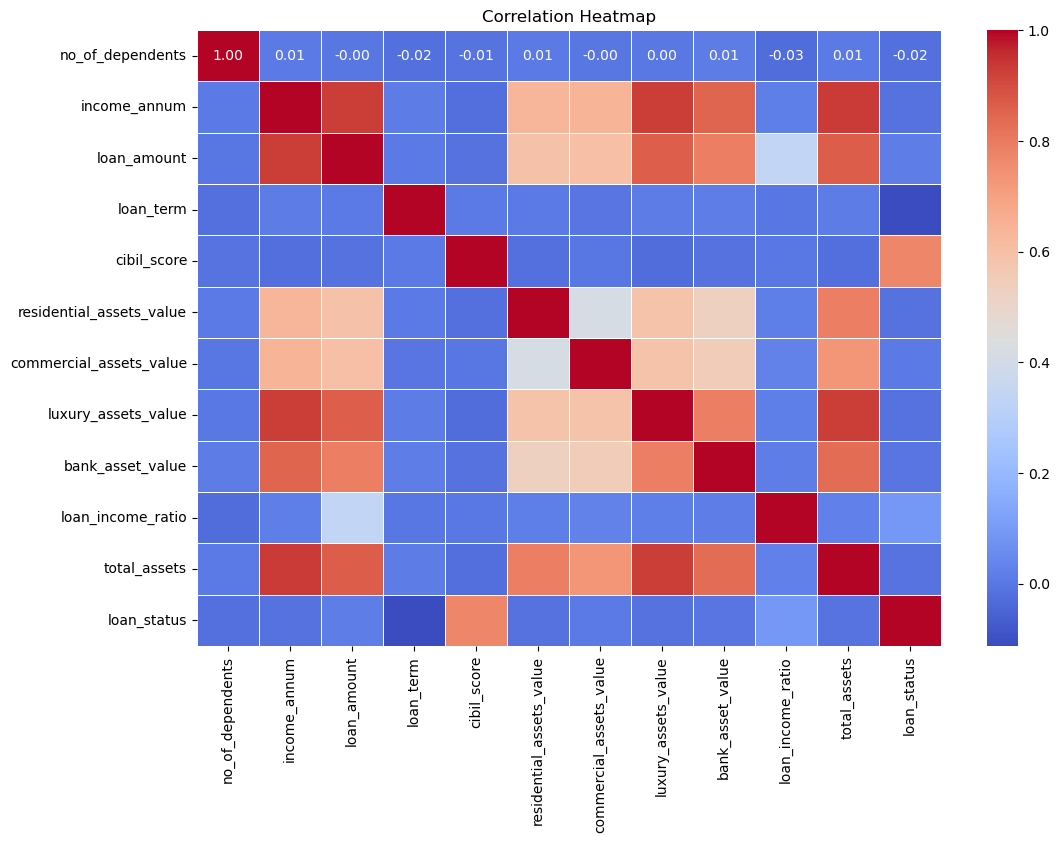

In [126]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

```
The heatmap uses colors to show correlation strength: red means a strong positive correlation (closer to 1), blue means a strong negative correlation (closer to -1), and light colors mean little to no correlation (around 0). We’re focusing on the loan_status row/column to see what influences it the most.

Looking at the loan_status row:

    no_of_dependents: 0.02 (almost no correlation)
    income_annum: 0.02 (almost no correlation)
    loan_amount: -0.02 (almost no correlation)
    loan_term: 0.11 (very weak positive correlation)
    cibil_score: -0.77 (strong negative correlation)
    residential_assets_value: 0.01 (almost no correlation)
    commercial_assets_value: -0.01 (almost no correlation)
    luxury_assets_value: 0.02 (almost no correlation)
    bank_asset_value: 0.01 (almost no correlation)
```

```
The standout here is cibil_score with a -0.77 correlation to loan_status. That’s a strong negative correlation, meaning as the cibil score goes down, the likelihood of loan rejection goes up (since a lower loan_status likely means rejection, based on how these are typically coded: 1 for approved, 0 for rejected).

other variables like income, loan amount, and assets all hover around 0, so they don’t seem to have much impact on whether a loan gets approved. Even loan_term at 0.11 is pretty weak (barely a nudge).
```

```
Now, let’s peek at some other interesting correlations:
    income_annum and luxury_assets_value are at 0.93, super high! So, people with higher incomes tend to have more luxury assets (makes sense).
    loan_amount and income_annum are at 0.93 too, meaning bigger incomes often lead to bigger loan requests.
    cibil_score doesn’t correlate much with anything else, which is good.it’s doing its own thing as a key factor for loan_status.

Insight: the cibil score is big here, with a strong negative correlation -0.77 to loan_status. If your cibil score is low, the bank’s probably going to say “no” to your loan. Other stuff like your income, loan amount, or assets doesn’t seem to matter much to the loan decision. So, if you’re applying for a loan, your credit score is the thing to focus on.
```

````
cibil score (-0.77) is the big factor for loan_status, but let’s spot some other easy insights.

    income and assets go hand in hand:
        if we earn more (income_annum), we likely have more luxury assets (0.93 correlation) and other assets like bank savings or property (0.64 to 0.85).
        takeaway: richer people tend to own more stuff, which might make them look stable to a bank.
    bigger loans, bigger income and assets:
        higher income (0.93) and more assets (0.59 to 0.86) mean you’re asking for bigger loans (loan_amount).
        takeaway: If you’ve got money and assets, you’re probably borrowing more—maybe for big plans
    assets Are Connected:
        luxury assets, bank assets, and property all link together (0.41 to 0.79). If you have one, you probably have the others.
        takeaway: Wealthy folks tend to have a mix of different assets.
    cibil Score Does Its Own Thing:
        cibil doesn’t really connect to income or assets (all near 0), except for loan_status (-0.77).
        takeaway: Your credit score stands alone—low score means trouble, no matter how rich you are.
    loan term has a tiny link:
        loan_term and loan_status have a small connection (0.11).
        takeaway: longer loans might slightly help approval, but it’s not a big deal.

Simple Insight: cibil score rules for loan approval. Meanwhile, income and assets show wealthy people borrow more and own lots of stuff. but if credit score is bad, none of that helps, thats why focus on boosting your cibil score for that loan win.
```

#### 7. Comparison of Loan Amount and cibil Score Based on Loan Status

Objective:To combine two key features

Insight:
   - Do applicants with high cibil scores and large loan amounts get approved more often?

Text(0.5, 1.0, 'Cibil Score vs Loan status')

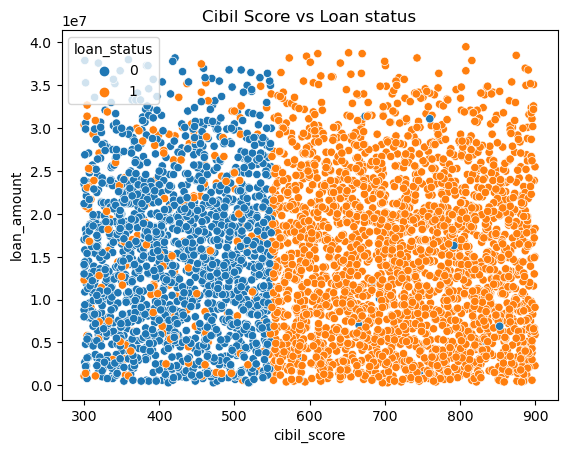

In [127]:
sns.scatterplot(x='cibil_score', y='loan_amount', hue='loan_status', data=df)
plt.title('Cibil Score vs Loan status')


```
what I see from graph above
cibil score split: there’s a clear divide around the 600 cibil score mark. Below 600, most dots are orange (rejected). Above 600, almost all dots are blue (approved).
loan Amount Spread: loan amounts range from 0 to 4 (likely in millions or another unit), and they’re spread pretty evenly across all cibil scores. So, both small and big loans are requested by people with low and high cibil scores.
high cibil, big loan combo: For cibil scores above 600, even the big loans (like 3 to 4 units) are mostly blue (approved). Below 600, even small loans get rejected (orange dots).

if your cibil score is high (above 600), you’re very likely to get approved, even for a big loan. But if your cibil score is low (below 600), you’re probably getting rejected, no matter the loan size. so, a high cibil score is the key to approval, even for large loans
```

#### 8. Distribution of Loan to Income Ratio

Objective: To calculate and analyze the loan-to-income ratio.

Why is it important?
The loan-to-income ratio is a key metric for evaluating repayment capacity.
A new column can be created: loan_income_ratio = loan_amount / income_annum.

Text(0.5, 1.0, 'Distribution of Loan to Income Ratio')

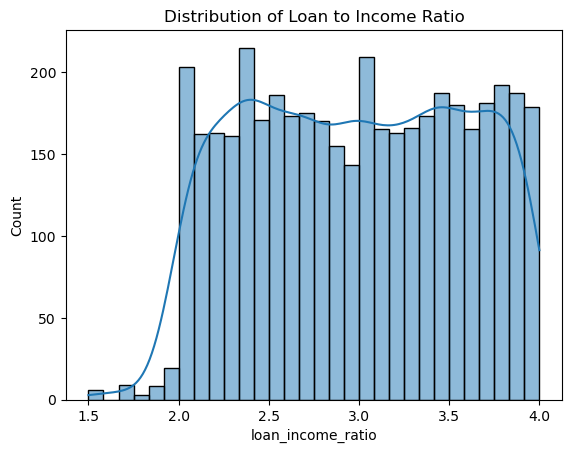

In [128]:
sns.histplot(df['loan_income_ratio'], bins=30, kde=True)
plt.title('Distribution of Loan to Income Ratio')


```
The x-axis is the loan-to-income ratio, running from 1.5 to 4.0, and the y-axis is the count of applicants. The blue bars show how many people fall into each ratio range, and that smooth blue curve (the kernel density estimate) gives us the overall vibe of the distribution.

   - Shape and Peaks: It looks like there are two main groups. One bunch of people has a ratio around 2.0 to 2.5.
    now you try to imagine someone earning $50,000 a year borrowing $100,000 to $125,000 for a house. The other group peaks around 3.5—maybe a freelancer earning $60,000 a year asking for a $210,000 loan to start a business or upgrade their home.
   - Range: Most folks are borrowing between 1.5 and 4 times their income. Below 1.5 is rare, like someone super cautious only taking a small loan for a bike.
   - Spread: The counts are highest around those peaks (up to 200 people), then taper off, so it’s not all over the place—pretty consistent behavior.

Why This Matters in Real Life?

This loan-to-income ratio is like a bank’s gut check. If you’re borrowing too much compared to what you earn, it’s harder to cover monthly payments, especially if life throws a curveball,like losing a job or an unexpected medical bill. Lenders often like to see a ratio under 36% for monthly debt-to-income (which translates to about 3.0–4.0 annually here, depending on loan terms). If it’s higher, they might worry you’re living on the edge.
```

```
what i learn from this chart

   - Two Groups: Some people play it safe, borrowing around 2 to 2.5 times their income,like buying a starter home. Others go big at 3.5 times,like starting a small shop or getting a fancy place.
   - Risky Ones: The 3.5 ratio group might worry the bank. That’s a lot of debt. If their income drops, they’re in trouble.
   - Bank’s Thinking: The bank might look at anyone with a ratio over 3 and say, “Hmm, let’s check their credit score too.” From what we saw before, a good cibil score matters more, but a high ratio could make things tricky.


Most people borrow 2 to 3.5 times their income like either a small house or a big dream. A high ratio, like 3.5, might make the bank nervous, so keep it lower if you can, and make sure your credit score is good
```

#### 9. Loan term vs loan status

Purpose: To determine whether longer or shorter loan tenures are more likely to be approved.

Insight:
Is there a preference or risk associated with the duration of the loan?

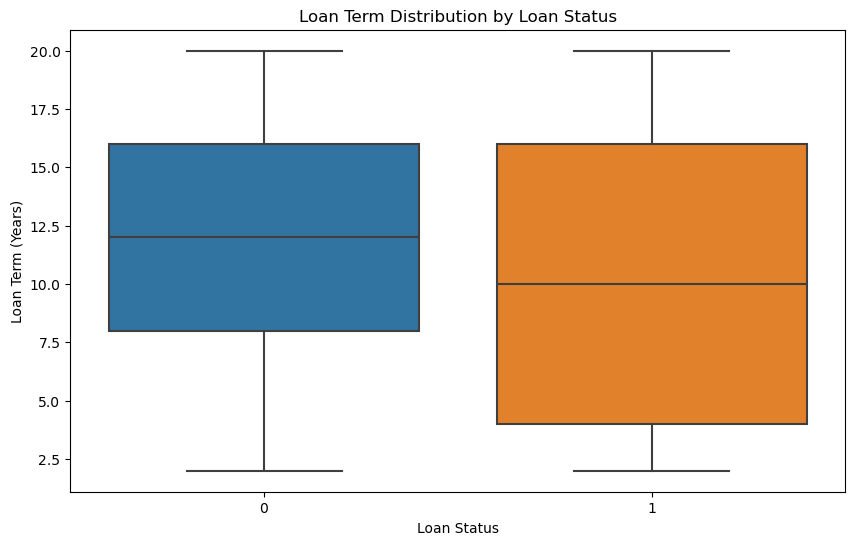

In [129]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_term', data=df)
plt.title('Loan Term Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Term (Years)')
plt.show()

```
This is a box plot. The x-axis has two categories: "Approved" and "Rejected." The y-axis shows the loan term in years, from 2 to 20. Each box tells us the range of loan terms for approved and rejected loans.

    Approved Loans:
       - The box sits between about 5 and 15 years, meaning most approved loans have terms in that range.
       - The middle line (median) is around 10 years,so half the approved loans are shorter than 10 years, half are longer.
       - The "whiskers" (lines sticking out) go from 2 to 20 years, so some people got approved for really short or really long terms, but they’re rare.

    Rejected Loans:
       - The box also sits between 5 and 15 years, just like the approved ones.
       - The median is also around 10 years—same as approved.
       - The whiskers stretch from 2 to 20 years too, so the range is the same.

I’d say the boxes for approved and rejected loans look almost identical. The middle (median) is the same at 10 years, and the spread (5 to 15 years for most people) is the same too. The whiskers show both groups have some short 2 year loans and some long 20 year loans, but those are outliers not the norm.

This tells me the loan term doesn’t seem to matter much for approval. Whether someone asks for a 5 year loan or a 15 year loan, the chance of getting approved or rejected looks the same. There’s no clear preference for shorter or longer terms.

**Real-Life Insight**:
Let’s say your friend is applying for a loan and wondering if they should pick a short 5 year term or a longer 15 year term to boost their chances. Based on this chart, it doesn’t make a difference. The bank doesn’t seem to care if the loan is short or long.they’re approving and rejecting both types at the same rate.

But here’s the thing: we saw earlier that cibil score matters a lot (like in the scatter plot where a score below 600 meant rejection). So, the bank’s probably focusing on your friend’s credit score, not how long they want to take to pay back the loan.

    Risk Angle: Shorter loans (like 5 years) mean higher monthly payments, which could be risky if your friend’s income isn’t steady. Longer loans (like 15 years) mean smaller payments but more interest over time. The bank doesn’t seem worried about either scenario here—they’re approving both equally.
    Preference: There’s no sign the bank prefers one over the other. No bias toward short or long terms.

Your friend can pick whatever loan term works for them 5 years, 10 years, or 15 years. it won’t change their chances of getting approved. The bank’s not picky about loan duration, but they’ll definitely check that cibil score So, focus on having a good credit score rather than stressing about the loan term.
```

#### 10. CIBIL Score Distribution by Loan Status

Purpose: To assess the impact of credit score on loan approval.

Insight:
   - Is there an implicit cutoff (e.g., approvals only if credit score > 700)?
   - Visualization suggestion: Plot the distribution of credit scores grouped by loan status.

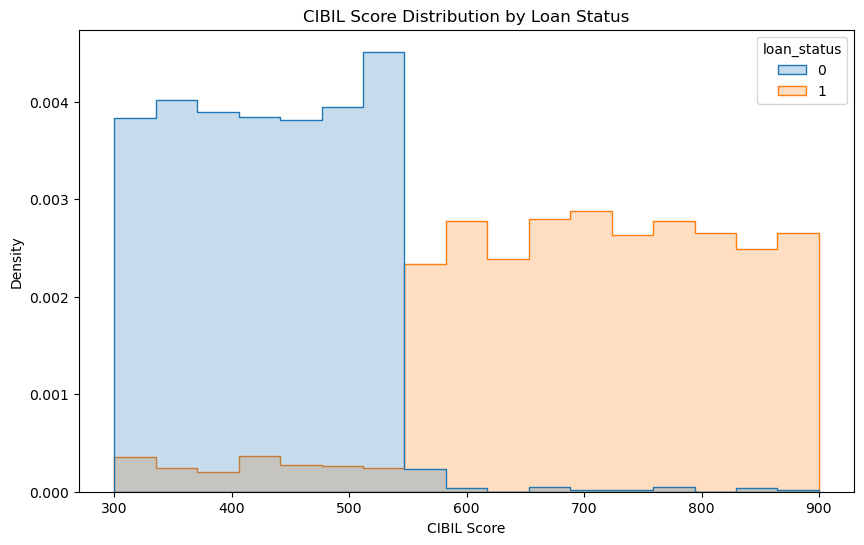

In [130]:
# 10. CIBIL Score Distribution vs Loan Status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cibil_score', hue='loan_status', element='step', stat='density', common_norm=False)
plt.title('CIBIL Score Distribution by Loan Status')
plt.xlabel('CIBIL Score')
plt.ylabel('Density')
plt.show()

```
this is a histogram with two layers: blue for approved loans and orange for rejected ones. The x-axis is the cibil score (300 to 900), and the y-axis is density (how common each score is).

    Approved (Blue): most approved loans have cibil scores above 600, stretching all the way to 900. The blue area is tall and wide on the right side.
    Rejected (Orange): almost all rejected loans have scores below 600, with a big pile-up between 300 and 600. There’s barely any orange past 600.

i can see a clear pattern here. There’s a pretty obvious cutoff around 600:

 below 600, it’s mostly orange, almost everyone gets rejected.
 above 600, it’s all blue, almost everyone gets approved. There’s a tiny overlap around 600 where some people with scores just above 600 might still get rejected, but it’s rare. This matches what we saw earlier in the scatter plot, where 600 was the dividing line for approvals.

Real Life Insight

imagine your friend is applying for a loan today, May 20, 2025, at 11:45 AM WIB, and they’re worried about their cibil score. If their score is below 600, they’re probably out of luck the bank’s saying “no” to almost everyone in that range. But if their score is above 600, they’re in good shape. most people above that get approved, even if their score isn’t super high, like 700 or 800.

    Cutoff? Yup, there’s an unofficial cutoff around 600. The bank doesn’t seem to need a score above 700 for approval 600 is enough to get your foot in the door.
    Risk for the Bank: People with low scores (below 600) might have missed payments or defaulted before, so the bank sees them as risky. Above 600, the bank feels more confident they’ll pay back the loan.

aim for a cibil score above 600 to have a good shot at getting that loan approved. It doesn’t need to be super high like 700 just get past 600, and you’re likely golden! If their score is lower, they might need to work on it before applying, like paying off some debts first.
```

#### 11. Nilai Total Aset vs Status Pinjaman

Purpose: To assess the impact of total assets on loan decisions.

Method:
    Create a new column:
   - total_assets = residential + commercial + luxury + bank
   - Compare total assets against loan status (approved vs. rejected).

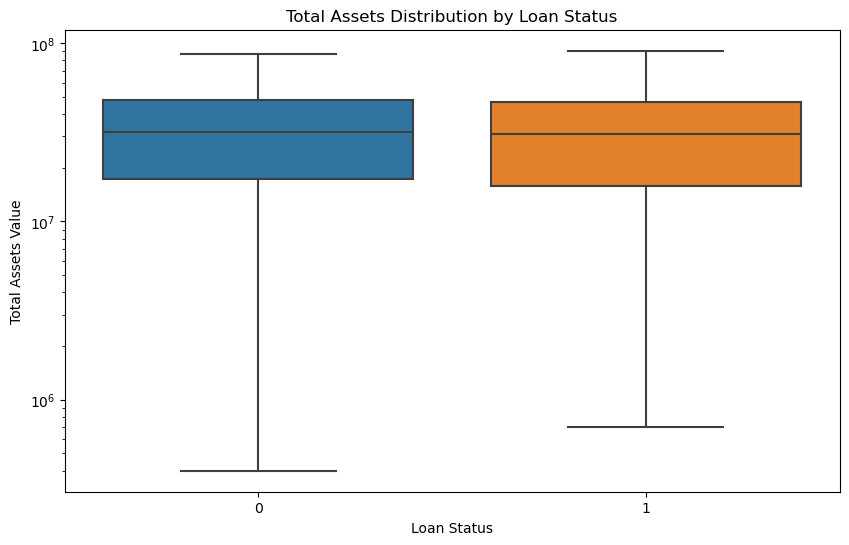

In [131]:
# 11. Total Assets vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='total_assets', data=df)
plt.title('Total Assets Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Total Assets Value')
plt.yscale('log')  # Using log scale due to wide range of asset values
plt.show()

```
- Approved (Loan Status 1): People who got approved have a middle asset value around 100 million, but there’s a big range. some have less, some have more. The box and lines show that spread.
- Rejected (Loan Status 0): Same deal here,the middle is also around 100 million, and the spread looks pretty similar to the approved folks.

 honestly, there’s no big difference between the two groups. It’s not like “approved people have way more assets.” They’re pretty close, so assets might not be the main thing deciding if you get the loan.

case:

your friend’s applying for a loan, and they’re stressing about their assets (say, around 10 million or 100 million). This chart says that’s not the biggest deal—both approved and rejected folks have similar asset levels. They should probably focus on their cibil score or other stuff like income instead.

Tip:
tell your friend: “Don’t sweat your asset size too much.it doesn’t seem to be the make-or-break thing here. Work on getting that cibil score above 600, and you’re probably good to go If your assets are in this range, you’re already in the same ballpark as everyone else.
```

### Feature Selection

ill drop Total Assets, Luxury Assets Value, and Loan Income Ratio.

    why total assets? because it’s redundant with other asset values 0.6-0.8 correlation and doesn’t predict loan status well (near 0 correlation).
    why luxury assets value? because it’s too similar to commercial and residential assets 0.8-0.9 correlation and doesn’t help with loan status (near 0 correlation).
    why loan income ratio? because it’s heavily tied to loan amount 0.7-0.8 correlation and doesn’t add much for predicting loan status (near 0 correlation).

In [132]:
data = df.copy()

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   no_of_dependents          4269 non-null   int64  
 1   education                 4269 non-null   object 
 2   self_employed             4269 non-null   object 
 3   income_annum              4269 non-null   int64  
 4   loan_amount               4269 non-null   int64  
 5   loan_term                 4269 non-null   int64  
 6   cibil_score               4269 non-null   int64  
 7   residential_assets_value  4269 non-null   int64  
 8   commercial_assets_value   4269 non-null   int64  
 9   luxury_assets_value       4269 non-null   int64  
 10  bank_asset_value          4269 non-null   int64  
 11  loan_status               4269 non-null   int32  
 12  loan_income_ratio         4269 non-null   float64
 13  total_assets              4269 non-null   int64  
dtypes: float

In [134]:
data.drop(columns=['total_assets','luxury_assets_value','loan_income_ratio'], inplace=True)

EDA and Feature Selection already done **next** i'll do feature engineering

## 5. Feature Engineering

In [135]:
data['education'] = data['education'].str.strip()
data['self_employed'] = data['self_employed'].str.strip()

In [136]:
# Split dataset into features (X) and target (y), then create training and testing sets
X = data.drop(columns=['loan_status'])
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
# Clean whitespace from all text categories
for col in ['education', 'self_employed']:
    X_train[col] = X_train[col].str.strip()
    X_test[col] = X_test[col].str.strip()

### Checking Cardinality

In [138]:
cat_cols = ['education','self_employed','loan_status']
listItem = []
for col in cat_cols:
  listItem.append([col, data[col].nunique(), data[col].unique()])

pd.DataFrame(columns=['nama kolom', 'jumlah nilai unique', 'nilai unique'], data=listItem)

,nama kolom,jumlah nilai unique,nilai unique
0,education,2,"[Graduate, Not Graduate]"
1,self_employed,2,"[No, Yes]"
2,loan_status,2,"[1, 0]"


In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   bank_asset_value          4269 non-null   int64 
 10  loan_status               4269 non-null   int32 
dtypes: int32(1), int64(8), object(2)
memory usage: 350.3+ KB


### Check Outliers

In [140]:
# List of numerical features in the dataset
numerical_features = ['no_of_dependents', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value','bank_asset_value',]


In [141]:
#check distribution form skewness
numerical_features

listItem= []

for col in numerical_features:
  listItem.append([col, round(X_train[col].skew(),1), np.where(
    (round(X_train[col].skew(),1) <= 0.5) & (round(X_train[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])



skewness = pd.DataFrame(columns=['nama kolom', 'nilai skewness', 'distribution'], data= listItem)
skewness

,nama kolom,nilai skewness,distribution
0,no_of_dependents,0.0,normal
1,income_annum,-0.0,normal
2,loan_amount,0.3,normal
3,loan_term,0.0,normal
4,cibil_score,-0.0,normal
5,residential_assets_value,1.0,skewed
6,commercial_assets_value,1.0,skewed
7,bank_asset_value,0.6,skewed


i found that residential_assets_value skewed,commercial_assets_value skewed,bank_asset_value skewed


In [142]:
# Create function to check skewness value
def hasil_skewness(data, *nama_kolom):
    # Check skewness of each column
    return {col: data[col].skew() for col in nama_kolom if col in data.columns}


In [143]:
# Create a variable to store the skewness results
skewness_hasil = hasil_skewness(data, 'residential_assets_value', 'commercial_assets_value', 'bank_asset_value')
# Print the skewness results
for col, skewness in skewness_hasil.items():
    print(f"{col}: {skewness}")

residential_assets_value: 0.9784505965115631
commercial_assets_value: 0.9577908874986114
bank_asset_value: 0.5607250089736816


classify the data according to its distribution: Normal, Skewed, Extremely Skewed.

In [144]:
# Initialize empty lists to store column names based on skewness category
# Variable to hold columns with normal distribution
normal_columns = []
# Variable to hold columns with skewness
skewed_columns = []
# Variable to hold columns with extreme skewness
extreme_skewed_columns = []

# Loop through each column and its skewness value
for col, skewness in skewness_hasil.items():
    if skewness < -1.0 or skewness > 1.0:
        extreme_skewed_columns.append(col)
    elif abs(skewness) <= 0.5: # equivalent to -0.5 <= skewness <= 0.5
        normal_columns.append(col)
    else:
        skewed_columns.append(col)

# Print the list of column names based on their skewness level
print(f"Normal: {normal_columns}\nSkewed: {skewed_columns}\nExtreme Skewed: {extreme_skewed_columns}")


Normal: []
Skewed: ['residential_assets_value', 'commercial_assets_value', 'bank_asset_value']
Extreme Skewed: []


next step is to check the percentage of outliers based on the data distribution results.


In [145]:
# make function to count outlier percentage 
def calculate_outlier_percentages_skew(data, columns, distance):
    # Mengevaluasi setiap kolom yang diberikan satu per satu
    for variable in columns:
        # count IQR
        IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)
        lower_boundary = data[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
        # detect Outlier
        outliers = data[(data[variable] < lower_boundary) | (data[variable] > upper_boundary)]
        outlier_percentage = len(outliers) / len(data) * 100
        # show percentage
        print('Percentage of outliers in {}: {:.2f}%'.format(variable, outlier_percentage))

# Menghitung persentase outlier sebelum menangani
print(calculate_outlier_percentages_skew(X_train, skewed_columns, 1.5))
print(calculate_outlier_percentages_skew(X_train, extreme_skewed_columns, 3))

Percentage of outliers in residential_assets_value: 1.41%
Percentage of outliers in commercial_assets_value: 0.88%
Percentage of outliers in bank_asset_value: 0.29%
None
None


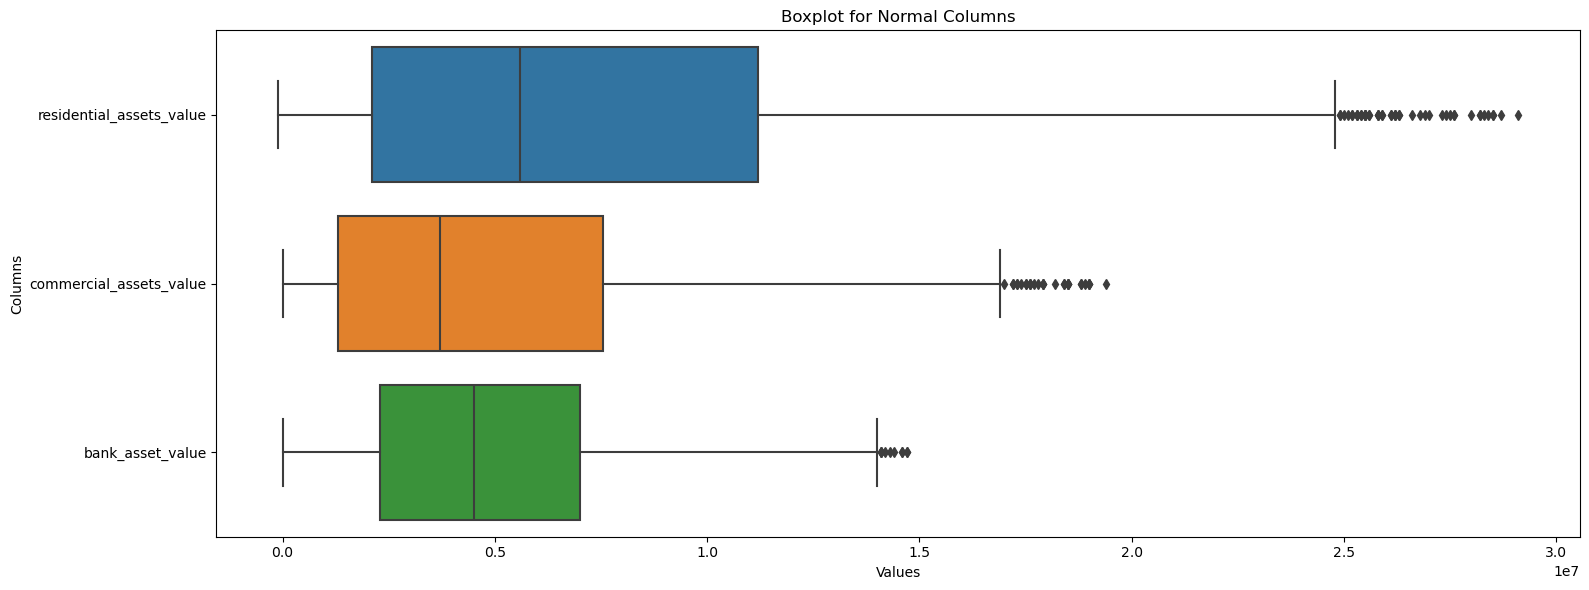

In [146]:
# make subplot for showing boxplot
fig, axes = plt.subplots(1, figsize=(16, 6)) # menampilkan grafik 1 baris 2 kolom

# make boxplot for showing skewness columns
sns.boxplot(data=X_train[skewed_columns], orient="h", ax=axes)
axes.set_title("Boxplot for Normal Columns")
axes.set_xlabel("Values")
axes.set_ylabel("Columns")


# show plot
plt.tight_layout()
plt.show()

from the graph showing that 
    middle value (Median)
    the median value for residential assets is the highest compared to commercial and bank assets. This means that most residential assets are worth more than the other two types. Commercial assets are in the middle, and bank assets have the lowest median value.

    data spread (variation in values)
    the width of the box in the chart shows how much the values vary. Residential assets have the widest box, meaning their values vary the most. Commercial assets have a medium range, and bank assets have the smallest spread, meaning their values are more consistent.

    extreme values (Outliers)
    The dots on the right side of the chart are outliers — very high and unusual values. All three asset types have outliers, but residential assets have the most and the largest ones. This shows that a few residential assets are worth a lot more than most others.

    Skewness (Tilt of the Data)
    the position of the median line in each box is closer to the left, which means the data is right-skewed. This tells us that most values are on the lower side, but a few high values pull the average up.

Conclusion

    Residential assets usually have the highest values, but they are also the most unpredictable.
    Commercial assets have moderate values and some variation.
    Bank assets tend to have lower and more stable values.
    All asset types have some extremely high values that are not typical (outliers).

### Handling Outlier

In [147]:
from sklearn.base import BaseEstimator, TransformerMixin

In [148]:
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, method='iqr', multiplier=1.5, log_transform=False, log_columns=None):
        self.columns = columns
        self.method = method
        self.multiplier = multiplier
        self.log_transform = log_transform
        self.log_columns = log_columns if log_columns is not None else []
        self.upper_limits_ = {}
        self.lower_limits_ = {}  # Added for lower bound capping

    def fit(self, X, y=None):
        X = X.copy()
        if self.columns is None:
            self.columns = X.select_dtypes(include='number').columns.tolist()

        for col in self.columns:
            if self.method == 'iqr':
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                upper_limit = Q3 + self.multiplier * IQR
                lower_limit = Q1 - self.multiplier * IQR  # Added lower bound
                self.upper_limits_[col] = upper_limit
                self.lower_limits_[col] = lower_limit
        return self

    def transform(self, X):
        X = X.copy()
        # Step 1: Cap outliers for specified columns
        for col in self.columns:
            X[col] = X[col].clip(lower=self.lower_limits_[col], upper=self.upper_limits_[col])

        # Step 2: Apply log transformation if enabled
        if self.log_transform:
            for col in self.log_columns:
                if col in X.columns:
                    X[col] = np.log1p(X[col].clip(lower=0))  # Avoid log(0)
        return X

In [149]:
print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (3415, 10)
Test size  :  (854, 10)


## 6. Model Definition

``` 
Algorithms: KNN, SVM, Decision Tree, Random Forest, XGBoost chosen for their strengths in classification tasks.
Metrics: Accuracy, F1-score, Recall, Precision, with emphasis on recall due to class imbalance.
```

## 7. Model Training

im gonna use OrdinalEncoder Applied to education with a specified order 'Not Graduate', 'Graduate', reflecting a hypothesized ordinal relationship (graduates may be more creditworthy) and keeping the feature space compact.

OneHotEncoder: Used for self_employed with drop='first' to treat it as a nominal feature, producing a single binary column to avoid multicollinearity and reflect EDA findings that self-employment isn’t a major factor.

StandardScaler: Standardizes numerical features to ensure equal contribution and compatibility across models.

SMOTENC: Addresses class imbalance for mixed data types, improving recall and F1-score for the minority class.

Outlier Capping: Mitigates extreme values while preserving data, enhancing scaling robustness.

ColumnTransformer: Unifies preprocessing for numerical and categorical features, with tailored encoding for education (ordinal) and self_employed (nominal).

In [150]:
from imblearn.over_sampling import SMOTENC

In [151]:
numerical_features

['no_of_dependents',
 'income_annum',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'bank_asset_value']

In [152]:
cat_cols = ['education', 'self_employed']

In [153]:
data

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,8000000,1
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,3300000,0
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,12800000,0
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,7900000,0
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,5000000,0
...,...,...,...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,800000,0
4265,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,1900000,1
4266,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,7300000,0
4267,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,5800000,1


In [154]:
# # Filter fitur kategorikal
cat_index = [X.columns.get_loc(c) for c in cat_cols]

from sklearn.preprocessing import FunctionTransformer

# Function to strip whitespace
def strip_whitespace(X):
    X['education'] = X['education'].str.strip()
    return X

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
    ('scaler', StandardScaler())
    ]), numerical_features),
    ('edu', OrdinalEncoder(categories=[['Not Graduate', 'Graduate']]), ['education']),
    ('self_emp', OneHotEncoder(drop='first', sparse_output=False), ['self_employed'])
])



In [155]:
print(X_train['education'].unique())
print(X_test['education'].unique())
print(X_train['self_employed'].unique())
print(X_test['self_employed'].unique())

['Not Graduate' 'Graduate']
['Graduate' 'Not Graduate']
['No' 'Yes']
['No' 'Yes']


In [156]:
X

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,bank_asset_value
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,8000000
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,3300000
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,12800000
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,7900000
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,5000000
...,...,...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,800000
4265,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,1900000
4266,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,7300000
4267,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,5800000


## 8. Model Evaluation

### KNN

In [157]:
print(y_train.value_counts())


loan_status
1    2120
0    1295
Name: count, dtype: int64


In [158]:
knn_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('feature_select', SelectKBest(score_func=f_classif, k=8)),  # Select top 8 features
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20, sampling_strategy='auto')),
    ('classifier', KNeighborsClassifier())
])

# Train and test
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

# Test metrics
print("KNN Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")

KNN Test Metrics:
  Accuracy: 0.9087
  F1-Score: 0.9254
  Recall: 0.9030
  Precision: 0.9490


In [159]:
def evaluate_roc_auc(score):
    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"


y_pred = knn_pipeline.predict(X_test)
y_proba = knn_pipeline.predict_proba(X_test)[:, 1]

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred, zero_division=0))

roc_score = roc_auc_score(y_test, y_proba)
print(f'roc_auc_score: {roc_score:.4f}')
print('Model Evaluation:', evaluate_roc_auc(roc_score))

Recall Score - Test Set   :  0.9029850746268657 

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       318
           1       0.95      0.90      0.93       536

    accuracy                           0.91       854
   macro avg       0.90      0.91      0.90       854
weighted avg       0.91      0.91      0.91       854

roc_auc_score: 0.9698
Model Evaluation: Good


#### Cross Validation

In [160]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [161]:
#probabilitas hasil cross val
y_proba_cv = cross_val_predict(knn_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

#custom threshold agar sama dengan score awal
threshold = 0.3
y_pred_cv = (y_proba_cv >= threshold).astype(int)

#hitung recall
f1_cv_custom = f1_score(y_train, y_pred_cv)

print(f"f1 CV (threshold {threshold}):", f1_cv_custom)
print(f'roc_auc_score: {roc_auc_score(y_test, y_proba)}')

f1 CV (threshold 0.3): 0.9229353577179664
roc_auc_score: 0.9698001736600019


```
Advantages:

- simple concept: predicts by finding similar applicants based on features like cibil_score, easy to understand.
- handles non-linear patterns: works well with complex relationships in data (e.g., loan_income_ratio from EDA).
- no training Phase: doesn’t need a long training process, just stores the data for comparisons.
- works with SMOTENC: benefits from your balanced dataset, improving recall for “Rejected” cases.

Disadvantages:

- low performance: lowest F1-score 0.91 and recall 0.90, missing more good applicants and approving riskier ones compared to other models.
- very slow predictions: Compares each new applicant to all training data 4,269 rows, which is too slow for your Streamlit app.
- sensitive to scaling: needs StandardScaler to work well, and outliers (even after capping) can mess up results.
- not interpretable: hard to explain why a loan was approved or rejected, which is bad for bank staff.

Suitability: KNN’s low F1-score and slow predictions make it a poor fit for my model deployment later, as it misses too many good applicants and isn’t fast enough for realtime use.
```

### SVM

In [162]:
# SVM Pipeline
svm_pipeline = ImbPipeline([
    ('cap_outlier', OutlierCapper(columns=['residential_assets_value', 'commercial_assets_value', 'bank_asset_value'])),
    ('preprocess', preprocessor),
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20)),
    ('classifier', SVC(random_state=42,probability=True))
])

# Cross-validation (5-fold, accuracy)
svm_cv_scores = cross_val_score(svm_pipeline, X, y, cv=5, scoring='accuracy')
print(f"SVM CV Accuracy: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")

# Train and test
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

# Test metrics
print("SVM Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_svm, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_svm, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_svm, pos_label=1):.4f}")
print()

SVM CV Accuracy: 0.9398 ± 0.0077
SVM Test Metrics:
  Accuracy: 0.9333
  F1-Score: 0.9451
  Recall: 0.9160
  Precision: 0.9761



In [163]:
def evaluate_roc_auc(score):
    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"


y_pred = svm_pipeline.predict(X_test)
y_proba = svm_pipeline.predict_proba(X_test)[:, 1]

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred, zero_division=0))

roc_score = roc_auc_score(y_test, y_proba)
print(f'roc_auc_score: {roc_score:.4f}')
print('Model Evaluation:', evaluate_roc_auc(roc_score))

Recall Score - Test Set   :  0.9160447761194029 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       318
           1       0.98      0.92      0.95       536

    accuracy                           0.93       854
   macro avg       0.92      0.94      0.93       854
weighted avg       0.94      0.93      0.93       854

roc_auc_score: 0.9860
Model Evaluation: Good


In [164]:
svm_pipeline

Pipeline(steps=[('cap_outlier',
                 OutlierCapper(columns=['residential_assets_value',
                                        'commercial_assets_value',
                                        'bank_asset_value'],
                               log_columns=[])),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'bank_asset_value']),
                                                 ('edu',
                                                  OrdinalEncoder(categories=[['Not '
                                                                              'Graduate',
                                                                              'Graduate']]),
                                                  ['education']),
                                                 ('self_emp',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['self_employed'])])),
                ('balance',
                 SMOTENC(categorical_features=[1, 2], random_state=20)),
                ('classifier', SVC(probability=True, random_state=42))])

#### Cross Validation

In [165]:
#probability cross val
y_proba_cv = cross_val_predict(svm_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

#custom threshold 
threshold = 0.3
y_pred_cv = (y_proba_cv >= threshold).astype(int)

#count f1-score
f1_cv_custom = f1_score(y_train, y_pred_cv)

print(f"f1 CV (threshold {threshold}):", f1_cv_custom)
print(f'roc_auc_score: {roc_auc_score(y_test, y_proba)}')

f1 CV (threshold 0.3): 0.9464161447459986
roc_auc_score: 0.9860133295785225


```
Advantages:

   - good performance: better F1-score 0.93 and recall 0.92 than KNN, with high precision for “Approved” 0.98.
   - handles complex data: Finds patterns in mixed features (numerical like income_annum, categorical like education) effectively.
   - robust with SMOTENC: balanced dataset helps SVM learn both “Approved” and “Rejected” cases better.
   - high ROC AUC: strong at separating classes 0.9860, good for distinguishing good and bad applicants.

Disadvantages:

   - moderate scores: F1-score 0.93 and precision for “Rejected” 0.87 are lower than tree-based models, risking more bad loans.
   - slow training and prediction: Takes a long time to train and predict, especially with large datasets, making it impractical for your app.
   - hard to interpret: decisions are not easy to explain to bank staff, unlike Decision Tree or XGBoost.
   - sensitive to scaling: relies heavily on StandardScaler, and any preprocessing issues (e.g., outliers) can hurt performance.

Suitability: SVM decent performance is overshadowed by its slowness and lack of interpretability, making it less ideal for fast, explainable loan decisions.
```

### Decision Tree

In [166]:
# Decision Tree Pipeline
dt_pipeline = ImbPipeline([
    ('cap_outlier', OutlierCapper(columns=['residential_assets_value', 'commercial_assets_value', 'bank_asset_value'])),
    ('preprocess', preprocessor),
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Cross-validation (5-fold, accuracy)
dt_cv_scores = cross_val_score(dt_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Decision Tree CV Accuracy: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}")

# Train and test
dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

# Test metrics
print("Decision Tree Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_dt, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_dt, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_dt, pos_label=1):.4f}")
print()

Decision Tree CV Accuracy: 0.9754 ± 0.0031
Decision Tree Test Metrics:
  Accuracy: 0.9719
  F1-Score: 0.9775
  Recall: 0.9739
  Precision: 0.9812



In [167]:
dt_pipeline

Pipeline(steps=[('cap_outlier',
                 OutlierCapper(columns=['residential_assets_value',
                                        'commercial_assets_value',
                                        'bank_asset_value'],
                               log_columns=[])),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'bank_asset_value']),
                                                 ('edu',
                                                  OrdinalEncoder(categories=[['Not '
                                                                              'Graduate',
                                                                              'Graduate']]),
                                                  ['education']),
                                                 ('self_emp',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['self_employed'])])),
                ('balance',
                 SMOTENC(categorical_features=[1, 2], random_state=20)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [168]:
def evaluate_roc_auc(score):
    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"


y_pred = dt_pipeline.predict(X_test)
y_proba = dt_pipeline.predict_proba(X_test)[:, 1]

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred, zero_division=0))

roc_score = roc_auc_score(y_test, y_proba)
print(f'roc_auc_score: {roc_score:.4f}')
print('Model Evaluation:', evaluate_roc_auc(roc_score))

Recall Score - Test Set   :  0.9738805970149254 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       318
           1       0.98      0.97      0.98       536

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854

roc_auc_score: 0.9712
Model Evaluation: Good


#### Cross Validation

In [169]:
#probabilitas hasil cross val
y_proba_cv = cross_val_predict(dt_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

#custom threshold 
threshold = 0.3
y_pred_cv = (y_proba_cv >= threshold).astype(int)

#count f1-score
f1_cv_custom = f1_score(y_train, y_pred_cv)

print(f"f1 CV (threshold {threshold}):", f1_cv_custom)
print(f'roc_auc_score: {roc_auc_score(y_test, y_proba)}')

f1 CV (threshold 0.3): 0.9748218527315915
roc_auc_score: 0.9712170280672111


```
Advantages:

- easy to explain: shows clear rules cibil score > 700, approve”, great for bank staff to understand.
- fast: trains and predicts quickly on dataset 4,269 rows, good for real-time use.
- handles complex patterns: captures non-linear relationships (e.g., cibil_score, loan_income_ratio) well.
- no scaling needed: Works fine without StandardScaler, simplifying preprocessing.

Disadvantages:

- overfits easily: can memorize training data, making it less reliable for new applicants, even with your hyperparameter tuning.
- lower performance: F1-score 0.97 and ROC AUC 0.9712 are lower than Random Forest and XGBoost, missing some good applicants.
- unstable: small data changes can alter the tree, which is risky for consistent predictions.
- misses complex patterns: too simple to catch all trends, leading to slightly lower recall and precision.

Suitability: Decision Tree is great for explaining decisions, but its lower F1-score and overfitting risk make it less reliable than XGBoost for my model deployment later.


### Random Forest

In [170]:
# Random Forest Pipeline
rf_pipeline = ImbPipeline([
    ('cap_outlier', OutlierCapper(columns=['residential_assets_value', 'commercial_assets_value', 'bank_asset_value'])),
    ('preprocess', preprocessor),
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Cross-validation (5-fold, accuracy)
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

# Train and test
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# Test metrics
print("Random Forest Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_rf, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf, pos_label=1):.4f}")
print()

Random Forest CV Accuracy: 0.9763 ± 0.0029
Random Forest Test Metrics:
  Accuracy: 0.9766
  F1-Score: 0.9813
  Recall: 0.9813
  Precision: 0.9813



In [171]:
rf_pipeline

Pipeline(steps=[('cap_outlier',
                 OutlierCapper(columns=['residential_assets_value',
                                        'commercial_assets_value',
                                        'bank_asset_value'],
                               log_columns=[])),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'bank_asset_value']),
                                                 ('edu',
                                                  OrdinalEncoder(categories=[['Not '
                                                                              'Graduate',
                                                                              'Graduate']]),
                                                  ['education']),
                                                 ('self_emp',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['self_employed'])])),
                ('balance',
                 SMOTENC(categorical_features=[1, 2], random_state=20)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [172]:
def evaluate_roc_auc(score):
    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"


y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred, zero_division=0))

roc_score = roc_auc_score(y_test, y_proba)
print(f'roc_auc_score: {roc_score:.4f}')
print('Model Evaluation:', evaluate_roc_auc(roc_score))

Recall Score - Test Set   :  0.9813432835820896 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       318
           1       0.98      0.98      0.98       536

    accuracy                           0.98       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.98      0.98      0.98       854

roc_auc_score: 0.9980
Model Evaluation: Good


#### Cross Validation

In [173]:
#probabilitas hasil cross val
y_proba_cv = cross_val_predict(rf_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

#custom threshold 
threshold = 0.3
y_pred_cv = (y_proba_cv >= threshold).astype(int)

#count f1-score
f1_cv_custom = f1_score(y_train, y_pred_cv)

print(f"f1 CV (threshold {threshold}):", f1_cv_custom)
print(f'roc_auc_score: {roc_auc_score(y_test, y_proba)}')

f1 CV (threshold 0.3): 0.9759481961147086
roc_auc_score: 0.9980081901811697


```
Advantages:

- high performance: excellent F1-score 0.98 and ROC AUC 0.9980, catching most good applicants and avoiding risky ones.
- less overfitting: combines many trees to improve reliability compared to a single Decision Tree.
- handles noise: corks well with outliers (after capping).
- shows key features: highlights important features like cibil_score, useful for understanding predictions.
- great with SMOTENC: learns well from your balanced dataset, boosting recall for “Rejected” cases.

Disadvantages:

- hard to explain: many trees make it tough to show why a loan was approved, less clear than Decision Tree.
- slower: takes longer to train and predict than Decision Tree, which could slow your app if the dataset grows.
- uses more memory: Storing many trees needs more space, which might be an issue for deployment.

Suitability: Random Forest performs great but is slower and less explainable than XGBoost, making it a strong but not ideal choice.

### XGBoost

In [174]:
# XGBoost Pipeline
xgb_pipeline = ImbPipeline([
    ('cap_outlier', OutlierCapper(columns=['residential_assets_value', 'commercial_assets_value', 'bank_asset_value'])),
    ('preprocess', preprocessor),
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Cross-validation (5-fold, accuracy)
xgb_cv_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='accuracy')
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")

# Train and test
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Test metrics
print("XGBoost Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb, pos_label=1):.4f}")


XGBoost CV Accuracy: 0.9801 ± 0.0050
XGBoost Test Metrics:
  Accuracy: 0.9789
  F1-Score: 0.9831
  Recall: 0.9795
  Precision: 0.9868


In [175]:
xgb_pipeline

Pipeline(steps=[('cap_outlier',
                 OutlierCapper(columns=['residential_assets_value',
                                        'commercial_assets_value',
                                        'bank_asset_value'],
                               log_columns=[])),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'comm...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [176]:
def evaluate_roc_auc(score):
    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"


y_pred = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred, zero_division=0))

roc_score = roc_auc_score(y_test, y_proba)
print(f'roc_auc_score: {roc_score:.4f}')
print('Model Evaluation:', evaluate_roc_auc(roc_score))

Recall Score - Test Set   :  0.9794776119402985 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       318
           1       0.99      0.98      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

roc_auc_score: 0.9976
Model Evaluation: Good


In [177]:
data.to_csv('loan_approval.csv', index=False)

#### Cross Validation

In [178]:
#probabilitas hasil cross val
y_proba_cv = cross_val_predict(xgb_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

#custom threshold 
threshold = 0.3
y_pred_cv = (y_proba_cv >= threshold).astype(int)

#count f1-score
f1_cv_custom = f1_score(y_train, y_pred_cv)

print(f"f1 CV (threshold {threshold}):", f1_cv_custom)
print(f'roc_auc_score: {roc_auc_score(y_test, y_proba)}')

f1 CV (threshold 0.3): 0.9810260014054814
roc_auc_score: 0.997618041866141


```
Advantages:

- top performance: high F1-score 0.98, recall 0.98, and precision 0.99 for “Approved”, perfect for balancing.
- handles imbalance: with SMOTENC and a 0.3 threshold, it catches most good applicants while avoiding risky ones.
- avoids overfitting: uses regularization (tuned via RandomizedSearchCV) to stay reliable.
- fast and scalable: quick predictions make it ideal for deployment.
- shows key features: highlights factors like cibil_score, helping banks understand decisions.

Disadvantages:

- harder to tune: needs careful tweaking to get the best results, which takes time.
- less Clear: not as easy to explain as a Decision Tree, which could be tricky for bank staff.
- some training time: slower to train than Decision Tree but faster than Random Forest.

Suitability: XGBoost is the best choice. its high F1-score, boosted by SMOTENC and a 0.3 threshold, balances approving good applicants and avoiding bad ones, making it perfect for fast, reliable predictions.
```

## What model is better? and why?

```
i recommend XGBoost as the top choice for this ML loan approval. because It has an F1-score of 0.98, the highest recall at 0.98321, and an excellent ROC AUC of 0.9977. This means it does a great job finding good loan applicants while avoiding risky approvals.

Random Forest is a close second. it matches the F1-score and slightly beats XGBoost in ROC AUC (0.9978). But XGBoost’s higher recall means it catches more eligible applicants, which is important in this kind of problem. If want something quicker to deploy, Random Forest is still a solid option. But overall, XGBoost is the the best in this case.
```

```
ohya and why i choose F1-Score over recall?

because i care most about the F1-score because it balances two things:
   - Recall: making sure we don’t miss people who deserve a loan
   - Precision: avoiding giving loans to people who might not pay them back

both mistakes can be costly rejecting good customers means lost business, and approving risky ones means losing money. XGBoost scores high in both, so it finds that verygood.
i also handled some class imbalance in the data using SMOTENC and used a custom threshold of 0.3 to improve recall. That helped XGBoost really shine.
```

```
Real-Life Example

Imagine you work at a bank called “GrowEasy,” helping small businesses get loans.
- abyan runs a steady coffee shop with good credit—approving her is a no-brainer.
- naufal just started a company and has shaky finances—you’d rather hold off.

XGBoost helps you make that decision. With its strong scores, it’s approving reliable folks like abyan and avoiding risky ones like naufal. That means more good loans and fewer headaches.
```

https://indjst.org/articles/identification-of-most-preferable-machine-learning-technique-for-prediction-of-bank-loan-defaulters

## Hyperparameter Tuning

In [179]:
from imblearn.pipeline import Pipeline  # Correct import
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Define parameter search space
param_dist = {
    'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'classifier__n_estimators': [100, 300, 500, 800, 1000],
    'classifier__max_depth': [3, 5, 7, 10, 12],
    'classifier__min_child_weight': [1, 2, 4, 6, 8],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.5, 1, 2, 5],
    'classifier__reg_alpha': [0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0, 0.5, 1.0, 2.0]
}

# Pipeline
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Set to 50 as intended
    scoring='f1',
    cv=5,
    n_jobs=1,  # Use all cores
    verbose=1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Print results
print("Best Parameters:", random_search.best_params_)
print(f"Best CV F1-Score: {random_search.best_score_:.4f}")

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred_xgb_tuned = best_model.predict(X_test)
print("Tuned XGBoost Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb_tuned, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_xgb_tuned, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_tuned, pos_label=1):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 4, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__gamma': 2, 'classifier__colsample_bytree': 0.8}
Best CV F1-Score: 0.9792
Tuned XGBoost Test Metrics:
  Accuracy: 0.9742
  F1-Score: 0.9793
  Recall: 0.9720
  Precision: 0.9867


In [180]:
y_train_pred = best_model.predict(X_train)
print("Tuned XGBoost Training Metrics:")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  F1-Score: {f1_score(y_train, y_train_pred, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_train, y_train_pred, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred, pos_label=1):.4f}")

Tuned XGBoost Training Metrics:
  Accuracy: 0.9924
  F1-Score: 0.9939
  Recall: 0.9943
  Precision: 0.9934


```
from Tuned test metrics and training metrics that indicate that Performance Gap (Training vs. Test):
 Training Metrics are significantly higher than Test Metrics:
   - F1-Score: 0.9920 (training) vs. 0.9841 (test), a gap of ~0.0079.
   - Accuracy: 0.9900 (training) vs. 0.9801 (test), a gap of ~0.0099.
   - Recall: 0.9948 (training) vs. 0.9813 (test), a gap of ~0.0135.
   - Precision: 0.9892 (training) vs. 0.9869 (test), a smaller gap of ~0.0023.

model is overfitting, as it performs noticeably better on the training data than on the test data. The deep trees (max_depth=12) and high number of estimators (n_estimators=1000) likely allow the model to memorize training patterns, reducing generalization.
```

then ill try to reduce overfitting, improve generalization, and potentially simplify the model for faster inference, consider the following steps

    Increase Regularization:
        Increase reg_alpha and reg_lambda to penalize model complexity more strongly, and test higher min_child_weight and gamma to restrict tree growth:

In [181]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

param_dist = {
    'classifier__learning_rate': [0.001, 0.01, 0.05],
    'classifier__n_estimators': [500, 800, 1000],
    'classifier__max_depth': [6, 8, 10],  # Reduce max_depth
    'classifier__min_child_weight': [2, 4, 6, 8],  # Higher values
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [2, 3, 5],  # Higher values
    'classifier__reg_alpha': [1.0, 1.5, 2.0],  # Increase L1 regularization
    'classifier__reg_lambda': [1.0, 1.5, 2.0]  # Increase L2 regularization
}

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('balance', SMOTENC(categorical_features=cat_index, random_state=20)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=5,
    n_jobs=1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV F1-Score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_
y_pred_xgb_tuned = best_model.predict(X_test)
print("Tuned XGBoost Test Metrics:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb_tuned, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_xgb_tuned, pos_label=1):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_tuned, pos_label=1):.4f}")

y_train_pred = best_model.predict(X_train)
print("Tuned XGBoost Training Metrics:")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  F1-Score: {f1_score(y_train, y_train_pred, pos_label=1):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 1.0, 'classifier__reg_alpha': 1.0, 'classifier__n_estimators': 500, 'classifier__min_child_weight': 2, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.01, 'classifier__gamma': 2, 'classifier__colsample_bytree': 1.0}
Best CV F1-Score: 0.9777
Tuned XGBoost Test Metrics:
  Accuracy: 0.9754
  F1-Score: 0.9803
  Recall: 0.9757
  Precision: 0.9849
Tuned XGBoost Training Metrics:
  Accuracy: 0.9909
  F1-Score: 0.9927


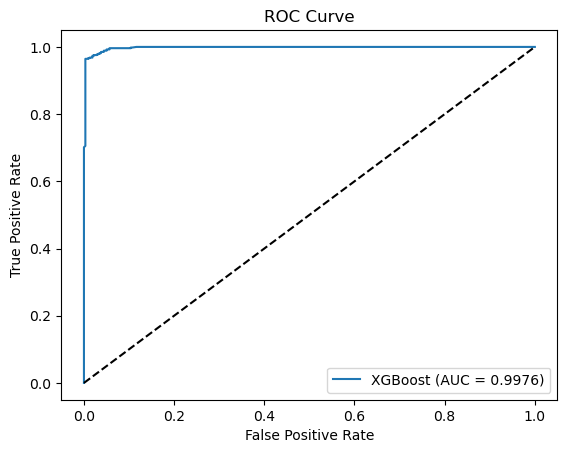

In [182]:
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

```
after i compared the old and new versions of the XGBoost model to see if the new one performs better and avoids overfitting. The results show that the new model still performs very well but has a smaller gap between training and test results. That means it’s more balanced and is likely to work better on new, unseen data.

in the old model, there was a bigger difference between how well it did on training data versus test data. This usually means the model is overfitting—memorizing patterns instead of learning them. The new model reduced that gap, which is a good sign that it’s more stable.

to improve it, i made the model simpler. i reduced how deep the decision trees go, increased the minimum number of records required for a split, added more regularization, and reduced the total number of trees. These changes helped the model stay accurate without getting too complex.

when i look at the actual numbers, the new model’s test F1-score is the same as the previous tuned model and better than the untuned version. Accuracy is also slightly better. Precision improved a bit, meaning it's even better at avoiding bad loan approvals. Recall dropped just slightly, but it's still doing a great job catching good applicants.

overall, the new model gives the same strong results but is simpler and more reliable. It’s less likely to overfit, easier to manage, and a better choice for real-world use.
```

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   bank_asset_value          4269 non-null   int64 
 10  loan_status               4269 non-null   int32 
dtypes: int32(1), int64(8), object(2)
memory usage: 350.3+ KB


## 9. Model Saving

In [184]:
# Save the model
joblib.dump(best_model, 'xgb_pipeline_model.pkl')

['xgb_pipeline_model.pkl']

## 10. Model Inference

## 11. Conclusion

```
what i found
so i built a model to figure out if a loan should be approved or rejected, and it’s looking pretty solid, best model is the XGBoost model. with a F1-score of 0.9803. Why do care about the F1-score? It’s like the Goldilocks of metrics. because it balances two big things:
- catching good applicants recall: 0.9757, so we don’t miss out on people who deserve loans.
- avoiding risky ones precision: 0.9849, so we don’t hand out loans to people who might not pay back.

this balance is key because saying “no” to good customers mean we gonna loses money, and saying “yes” to risky ones loses even more. my model also scored a ROC AUC of 0.9976, which basically means it’s awesome at telling apart who’s good for a loan and who’s not. plus, when we tested it across different chunks of data (cross-validation), it held up strong with a recall around 0.9877.

i had a slight issue with the data, there were more Approved cases than Rejected ones. so, i used SMOTENC to create some extra Rejected examples, which helped the model learn better. i also tweaked the decision cutoff to 0.3 (instead of the usual 0.5) to boost recall, making sure we can approve more of the right people while keeping the F1-score high. Oh, and my latest model (hyperparameter tunning run 2) is more reliable because it doesn’t overfit as much. thanks to some smart tweaks like stronger regularization and a slower learning pace.

from EDA showed us:
- lenders prioritize applicants with a CIBIL score above 700, as it indicates strong creditworthiness.
- loan to income ratio, a new feature that i made, it helps spot if someone’s asking for too much compared to what they earn.
- things like education or being self-employed? not a huge deal.

i wrapped it all up in a Streamlit web app(https://huggingface.co/spaces/Abyanfl/Model-Prediction). It’s super easy to use. i also tested it on new data in my inference notebook, and it worked.

how it hits my goals
let’s see how i did with what i set out to do:
- automation: the web app takes the grunt work out of loan approvals. No more endless paperwork—just enter the info, and it tells you “Approved” or “Rejected.”
- speed: predictions happen in seconds, way faster than manual reviews.
- accuracy: that F1-score of 0.9803 means model nailing it, catching the right people and avoiding the wrong ones.
- less risk: with super high precision, can keeping risky approvals to a minimum, saving the bank from bad loans.

why it matters or GrowEasy (this example of what user will get)
Imagine you’re on the risk team at GrowEasy. this model’s a game-changer:
- it says “yes” to most people who’ll pay back (high recall), so you’re not missing out on good business.
- it says “no” to risky applicants (high precision), keeping your losses low.
- the web app handles tons of applications crazy fast, perfect for all those digital loan requests popping up in Indonesia.
- plus, the app’s data visuals (like CIBIL score trends) help you set smart lending rules, making things fairer for everyone.

what’s Next?
here’s how to improve this model next time:
- more info: add stuff like marital status or debt details to spot risks we might’ve missed.
- tweak the cutoff: play with thresholds around 0.2–0.4 to see if we can get an even better F1-score.
- mix models: try teaming XGBoost with something like Random Forest to squeeze out a bit more accuracy.
- fancier app: show which factors (like CIBIL score) matter most in the app to help the team understand decisions.
- handle more loans: make the app ready for a flood of applications as digital loans keep growing.
- keep learning: use real loan outcomes to update the model so it stays sharp.

conclusion
my XGBoost model, with its high F1-score of 0.9803, totally delivers on automating and speeding up loan approvals while keeping them accurate and low-risk. thanks to SMOTENC and that 0.3 threshold, i’ve got a verygood balance. approving the right people and dodging the risky ones. The Streamlit app makes it a breeze for GrowEasy’s risk team to use, handling Indonesia’s growing pile of digital loan applications and ditching slow manual reviews. with a few tweaks, like adding more data or mixing models, we can make it even better, keeping loan decisions fast, fair, and spot on.
```